# home and work locations project - new york edition

#### (sandorjuhasz & kovacsa shared notebook)

In [1]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import seaborn as sns
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import matplotlib.gridspec as gridspec

import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon,LineString

import json
import time
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

## Census data prep 

In [2]:
#census data
census = pd.read_csv('../data/censusdata_top50_2012.csv')

In [3]:
names = pd.read_csv('../data/cbsacode_shortname_tracts.csv', sep = ";", index_col = 0)

In [4]:
names = names[names['short_name'] == 'New York']

In [5]:
# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

census['geoid'] = census.apply(create_geoid,axis=1)
census = pd.merge(census,names, on='geoid')

In [6]:
# geojson data, converted to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

init_crs = 4326 # lon,lat#merge geometries of tracts with census data 
new_columns = tract_geoms.columns.values  
new_columns[4] = 'geoid' 
tract_geoms.columns  = new_columns
merged = pd.merge(tract_geoms,census, on='geoid')
project_crs = 3857 # Cartesian systems

# projecting census tract geometries into the same Cartesian coordinate system as the user coordinates
tract_geoms.crs = {'init': 'epsg:' + str(init_crs)}

C:\Users\T440s\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
#merge geometries of tracts with census data 
new_columns = tract_geoms.columns.values  
new_columns[4] = 'geoid' 
tract_geoms.columns  = new_columns
merged = pd.merge(tract_geoms[['geometry', 'geoid']],census[['population', 'education_bachelor', 'education_total', 'income', 'race_total', 'white', 'black', 'native','asian', 'geoid']], on='geoid')

#drop those tracts where income<1000$
merged = merged[(merged['income']>1000)]

#create income groups (below or above median)
m = merged['income'].quantile(0.5)
merged['inc_group_2'] = ['poor' if (x < m) else 'rich' for x in merged['income']]

merged['l_income'] = np.log(merged['income'])
merged['l_population'] = np.log(merged['population'])
merged['white_prop'] = merged['white']/ merged['population']
merged['black_prop'] = merged['black']/ merged['population']
merged['asian_prop'] = merged['asian']/ merged['population']
merged['native_prop'] = merged['native']/ merged['population']
merged['education_bachelor_prop'] = merged['education_bachelor']/ merged['population']
merged.head()

,geometry,geoid,population,education_bachelor,education_total,income,race_total,white,black,native,asian,inc_group_2,l_income,l_population,white_prop,black_prop,asian_prop,native_prop,education_bachelor_prop
0,"POLYGON ((-73.96209 40.96961, -73.95826 40.983...",14000US34003007002,4357,1154,2924,53481.0,4357,2760,12,0,1576,rich,10.887082,8.379539,0.633463,0.002754,0.361717,0.000000,0.264861
1,"POLYGON ((-73.97598 40.95429, -73.97552 40.957...",14000US34003009100,4909,1209,3268,70209.0,4909,3636,4,0,1232,rich,11.159232,8.498826,0.740680,0.000815,0.250968,0.000000,0.246282
2,"POLYGON ((-73.99830 40.80848, -73.99783 40.809...",14000US34003006300,8134,1543,5900,34671.0,8134,6923,220,0,498,rich,10.453659,9.003808,0.851119,0.027047,0.061224,0.000000,0.189698
3,"POLYGON ((-73.98915 40.90930, -73.98861 40.911...",14000US34003015200,5958,1073,4321,35136.0,5958,2300,2219,13,626,rich,10.466982,8.692490,0.386036,0.372440,0.105069,0.002182,0.180094
4,"POLYGON ((-73.98486 40.87487, -73.98450 40.875...",14000US34003015500,6731,1579,4678,56793.0,6731,4804,864,52,290,rich,10.947168,8.814479,0.713713,0.128361,0.043084,0.007725,0.234586


## Network data prep

### data prep geo-nodelist 

In [8]:
# read in data about individuals -- userinfo - filter on geoinfo -- user_geo
userinfo = pd.read_csv('../data/usageousers_top50_common_data.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [9]:
#filter on New York
user_geon = user_geo[user_geo.index.isin([35620.0])].reset_index(drop = True)

In [10]:
# geometry cols
user_geon["geometry_h"] = user_geon.apply(lambda r: Point(r["lon_home"],r["lat_home"]), axis=1)

user_geon["geometry_w"] = user_geon.apply(lambda r: Point(r["lon_work"],r["lat_work"]), axis=1)

In [11]:
user_geon = user_geon[['user_id', 'geometry_h', 'geometry_w']]

### data prep -- geo_edgelist

In [14]:
# import follower network -- edgelist
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')

In [15]:
# merge edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [16]:
#filter on New York
edgelistn = edgelist[edgelist['cbsacode'] == 35620].reset_index(drop = True)

#### distance calculation - home-home and work-work

In [17]:
# geometry cols
edgelistn["geometry1_h"] = edgelistn.apply(lambda r: Point(r["lon_home1"],r["lat_home1"]), axis=1)
edgelistn["geometry2_h"] = edgelistn.apply(lambda r: Point(r["lon_home2"],r["lat_home2"]), axis=1)


edgelistn["geometry1_w"] = edgelistn.apply(lambda r: Point(r["lon_work1"],r["lat_work1"]), axis=1)
edgelistn["geometry2_w"] = edgelistn.apply(lambda r: Point(r["lon_work2"],r["lat_work2"]), axis=1)

geo_edgelistn = gpd.GeoDataFrame(edgelistn)

In [18]:
# change crs of h
geo_edgelistn = geo_edgelistn.set_geometry('geometry2_h')
geo_edgelistn.crs = {'init': 'epsg:4326'}
geo_edgelistn = geo_edgelistn.to_crs({'init': 'epsg:3857'})

geo_edgelistn = geo_edgelistn.set_geometry('geometry1_h')
geo_edgelistn.crs = {'init': 'epsg:4326'}
geo_edgelistn = geo_edgelistn.to_crs({'init': 'epsg:3857'})

# set geometry for dist caculation
geo_edgelistn = geo_edgelistn.set_geometry('geometry1_h')

# home-home distance calculation
geo_edgelistn['dist_hh'] = geo_edgelistn['geometry1_h'].distance(geo_edgelistn['geometry2_h'])

# change crs of w
geo_edgelistn = geo_edgelistn.set_geometry('geometry2_w')
geo_edgelistn.crs = {'init': 'epsg:4326'}
geo_edgelistn = geo_edgelistn.to_crs({'init': 'epsg:3857'})

geo_edgelistn = geo_edgelistn.set_geometry('geometry1_w')
geo_edgelistn.crs = {'init': 'epsg:4326'}
geo_edgelistn = geo_edgelistn.to_crs({'init': 'epsg:3857'})

# set geometry for distance calculation
geo_edgelistn = geo_edgelistn.set_geometry('geometry1_w')

# work-work distance calculation
geo_edgelistn['dist_ww'] = geo_edgelistn['geometry1_w'].distance(geo_edgelistn['geometry2_w'])

In [19]:
#filter on important columns
geo_edgelistn = geo_edgelistn[["user_id1", "user_id2", "geometry1_h", "geometry2_h", "geometry1_w", "geometry2_w", "dist_ww", "dist_hh" ]]

In [20]:
#bin distances
binsize=500

geo_edgelistn["dh_bin"] = binsize * (geo_edgelistn["dist_hh"] / binsize).map(int) + 500
geo_edgelistn["dw_bin"] = binsize * (geo_edgelistn["dist_ww"] / binsize).map(int) + 500

In [21]:
geo_edgelistn.head()

,user_id1,user_id2,geometry1_h,geometry2_h,geometry1_w,geometry2_w,dist_ww,dist_hh,dh_bin,dw_bin
0,4558,47,POINT (-8237085.721 4971716.568),POINT (-8232744.261 4970688.418),POINT (-8237085.721 4971716.568),POINT (-8236306.485 4968338.765),3466.520879,4461.543464,4500,3500
1,8286,47,POINT (-8231631.066 4983327.490),POINT (-8232744.261 4970688.418),POINT (-8236863.082 4974948.603),POINT (-8236306.485 4968338.765),6633.232143,12688.000195,13000,7000
2,12188,47,POINT (-8233189.539 4964521.782),POINT (-8232744.261 4970688.418),POINT (-8236083.846 4970982.164),POINT (-8236306.485 4968338.765),2652.758512,6182.690874,6500,3000
3,18713,47,POINT (-8236751.763 4976124.154),POINT (-8232744.261 4970688.418),POINT (-8237530.999 4972010.346),POINT (-8236306.485 4968338.765),3870.392956,6753.317635,7000,4000
4,36823,47,POINT (-8235861.207 4973185.543),POINT (-8232744.261 4970688.418),POINT (-8235861.207 4973185.543),POINT (-8236306.485 4968338.765),4867.189090,3993.868357,4000,5000


### Create degree tables (friends in x dist and shares)

In [22]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelistn.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [24]:
len(degree_tab)

44483

In [30]:
# remove users with less than 10 ties (!!!)
degree_tab = degree_tab[degree_tab["degree"] >= 10] 

In [32]:
len(degree_tab)

9357

In [33]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelistn.loc[geo_edgelistn.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [34]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelistn.loc[geo_edgelistn.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [37]:
# merge the resuls of the loops
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")
# replace NANs
d_table = d_table.fillna(0)

In [39]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c) + "_share"] = round((d_table[str(c)] / d_table["degree"]), 3)    

In [40]:
d_table.head()

,user_id,degree,dh500,dh1000,dh1500,dh2000,dh2500,dh3000,dh3500,dh4000,...,dw5500_share,dw6000_share,dw6500_share,dw7000_share,dw7500_share,dw8000_share,dw8500_share,dw9000_share,dw9500_share,dw10000_share
0,47,59,0.0,6.0,1.0,2.0,0.0,2.0,1.0,3.0,...,0.119,0.068,0.051,0.034,0.017,0.051,0.017,0.017,0.0,0.0
1,850,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0
2,977,10,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.100,0.0,0.1
3,1027,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0
4,1135,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.188,0.000,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0


### Same dataframe cumulatively

In [41]:
# loop -- HOME
dh_table_cum = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelistn.loc[geo_edgelistn.dh_bin <= d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table_cum = pd.merge(dh_table_cum, temp, on="user_id", how="left")

In [42]:
# loop -- WORK
dw_table_cum = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelistn.loc[geo_edgelistn.dw_bin <= d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table_cum = pd.merge(dw_table_cum, temp, on="user_id", how="left")

In [45]:
# merge the resuls of the loops
d_table_cum = pd.merge(dh_table_cum, dw_table_cum, on=["user_id", "degree"], how="left")
#replace NANs 
d_table_cum = d_table_cum.fillna(0)

In [47]:
# get the share of each degree
for c in list(d_table_cum.columns[2:,]):    
    d_table_cum[str(c) + "_share"] = round((d_table_cum[str(c)] / d_table_cum["degree"]), 3)

In [48]:
d_table_cum.head()

,user_id,degree,dh500,dh1000,dh1500,dh2000,dh2500,dh3000,dh3500,dh4000,...,dw5500_share,dw6000_share,dw6500_share,dw7000_share,dw7500_share,dw8000_share,dw8500_share,dw9000_share,dw9500_share,dw10000_share
0,47,59,0.0,6.0,7.0,9.0,9.0,11.0,12.0,15.0,...,0.627,0.695,0.746,0.780,0.797,0.847,0.864,0.881,0.881,0.881
1,850,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.062,0.062,0.062
2,977,10,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,...,0.400,0.400,0.400,0.400,0.400,0.400,0.400,0.500,0.500,0.600
3,1027,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1135,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.812,0.812,0.812,0.812,0.812,0.812,0.812,0.875,0.875,0.875


### Additional density of friends within next annulus around home with bootstrap ci

Bootstrapping via https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d

In [49]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    np.random.seed(30)
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [52]:
#select only absolute values from degree table (not share of friends)
d_table2b = d_table.iloc[:,0:42]

,user_id,degree,dh500,dh1000,dh1500,dh2000,dh2500,dh3000,dh3500,dh4000,...,dw5500,dw6000,dw6500,dw7000,dw7500,dw8000,dw8500,dw9000,dw9500,dw10000
0,47,59,0.0,6.0,1.0,2.0,0.0,2.0,1.0,3.0,...,7.0,4.0,3.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0
1,850,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,977,10,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1027,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1135,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,958562232,17,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
9353,971168960,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9354,971418698,10,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9355,994261874,17,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [53]:
d_table_geo = d_table2b.merge(user_geon, on = "user_id")
d_table_geo = gpd.GeoDataFrame(d_table_geo)
d_table_geo = d_table_geo.set_geometry('geometry_h')

In [54]:
d_table_geo_inc = gpd.sjoin(d_table_geo, merged[['geometry', 'inc_group_2']], 'left', 'within')

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  """Entry point for launching an IPython kernel.


In [56]:
d_table_geo_inc = d_table_geo_inc.drop(['index_right'], axis = 1)

In [58]:
d_table_geo_inc_r = d_table_geo_inc[d_table_geo_inc['inc_group_2'] == 'rich']

In [59]:
d_table_geo_inc_p = d_table_geo_inc[d_table_geo_inc['inc_group_2'] == 'poor']

In [60]:
#poor around home
d_table_geo_inc_p_h = d_table_geo_inc_p[['dh500','dh1000', 'dh1500','dh2000',
                     'dh2500','dh3000', 'dh3500','dh4000', 
                     'dh4500', 'dh5000', 'dh5500','dh6000',
                     'dh6500', 'dh7000','dh7500','dh8000',
                     'dh8500', 'dh9000','dh9500','dh10000']]

In [61]:
#rich around home
d_table_geo_inc_r_h = d_table_geo_inc_r[['dh500','dh1000', 'dh1500','dh2000',
                     'dh2500','dh3000', 'dh3500','dh4000', 
                     'dh4500', 'dh5000', 'dh5500','dh6000',
                     'dh6500', 'dh7000','dh7500','dh8000',
                     'dh8500', 'dh9000','dh9500','dh10000']]

## Home density plot

In [68]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = ['0-0.5','0.5-1', '1-1.5','1.5-2','2-2.5','2.5-3','3-3.5','3.5-4', '4-4.5', '4.5-5',
'5-5.5','5.5-6','6-6.5', '6.5-7','7-7.5','7.5-8','8-8.5','8.5-9','9-9.5', '9.5-10']
type1 = ["poor"] * 20 
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)])

for idx, c in enumerate(list(d_table_geo_inc_p_h.columns)):
    rownames.append(str(c))
    a = (draw_bs_replicates(d_table_geo_inc_p_h[str(c)], np.mean, 15000)*1/x[idx])*1/(0.25*np.pi)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb2 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb2 = pd.DataFrame(frameb2)

In [70]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = ['0-0.5','0.5-1', '1-1.5','1.5-2','2-2.5','2.5-3','3-3.5','3.5-4', '4-4.5', '4.5-5',
'5-5.5','5.5-6','6-6.5', '6.5-7','7-7.5','7.5-8','8-8.5','8.5-9','9-9.5', '9.5-10']
type1 = ["rich"] * 20 
x = np.concatenate([np.linspace(1,39,20),np.linspace(1,39,20)]) 

for idx, c in enumerate(list(d_table_geo_inc_r_h.columns)):
    rownames.append(str(c))
    a = (draw_bs_replicates(d_table_geo_inc_r_h[str(c)], np.mean, 15000)*1/x[idx])*1/(0.25*np.pi)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb3 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb3 = pd.DataFrame(frameb3)

In [72]:
conc1 = pd.concat([resultb2,resultb3])

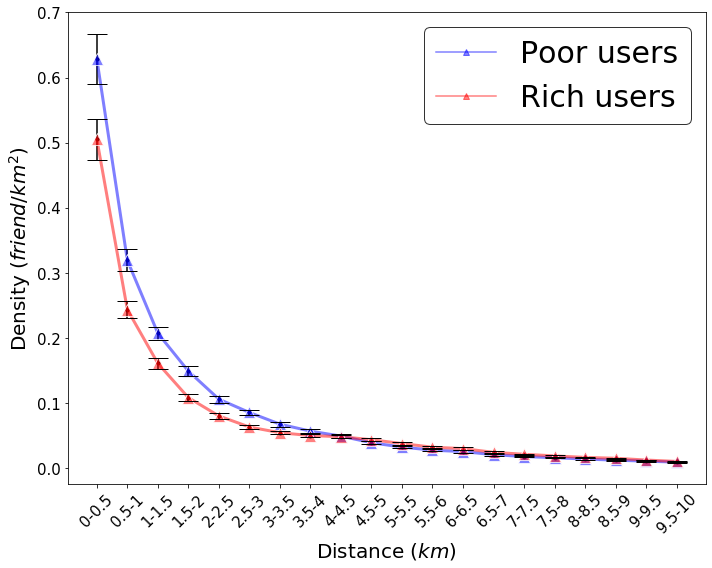

In [80]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(10, 8))

#colors of lines
colorsList = [(0.0, 0.0, 1.0,0.5),(1.0, 0.0, 0.0,0.5)]

#lineplots created
sns.lineplot(data = conc1, x = 'distance', y = 'mean', hue = 'type', style = 'type',palette = colorsList, ax = ax, markers=["^", "^"], markersize = 12, dashes = False, linewidth = 3)

ax.errorbar(data = conc1, x = 'distance', y = 'mean', yerr= [conc1['err_l'], conc1['err_u']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 30, edgecolor = 'black')
ax.set(xlabel='Distance $(km)$', ylabel='Density $(friend/km^2)$')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis = 'x',rotation = 45)

plt.tight_layout()

#plt.savefig('../figures/density_inc_h.jpg')

In [81]:
conc1_short = pd.concat([conc1[0:10], conc1[20:30]])

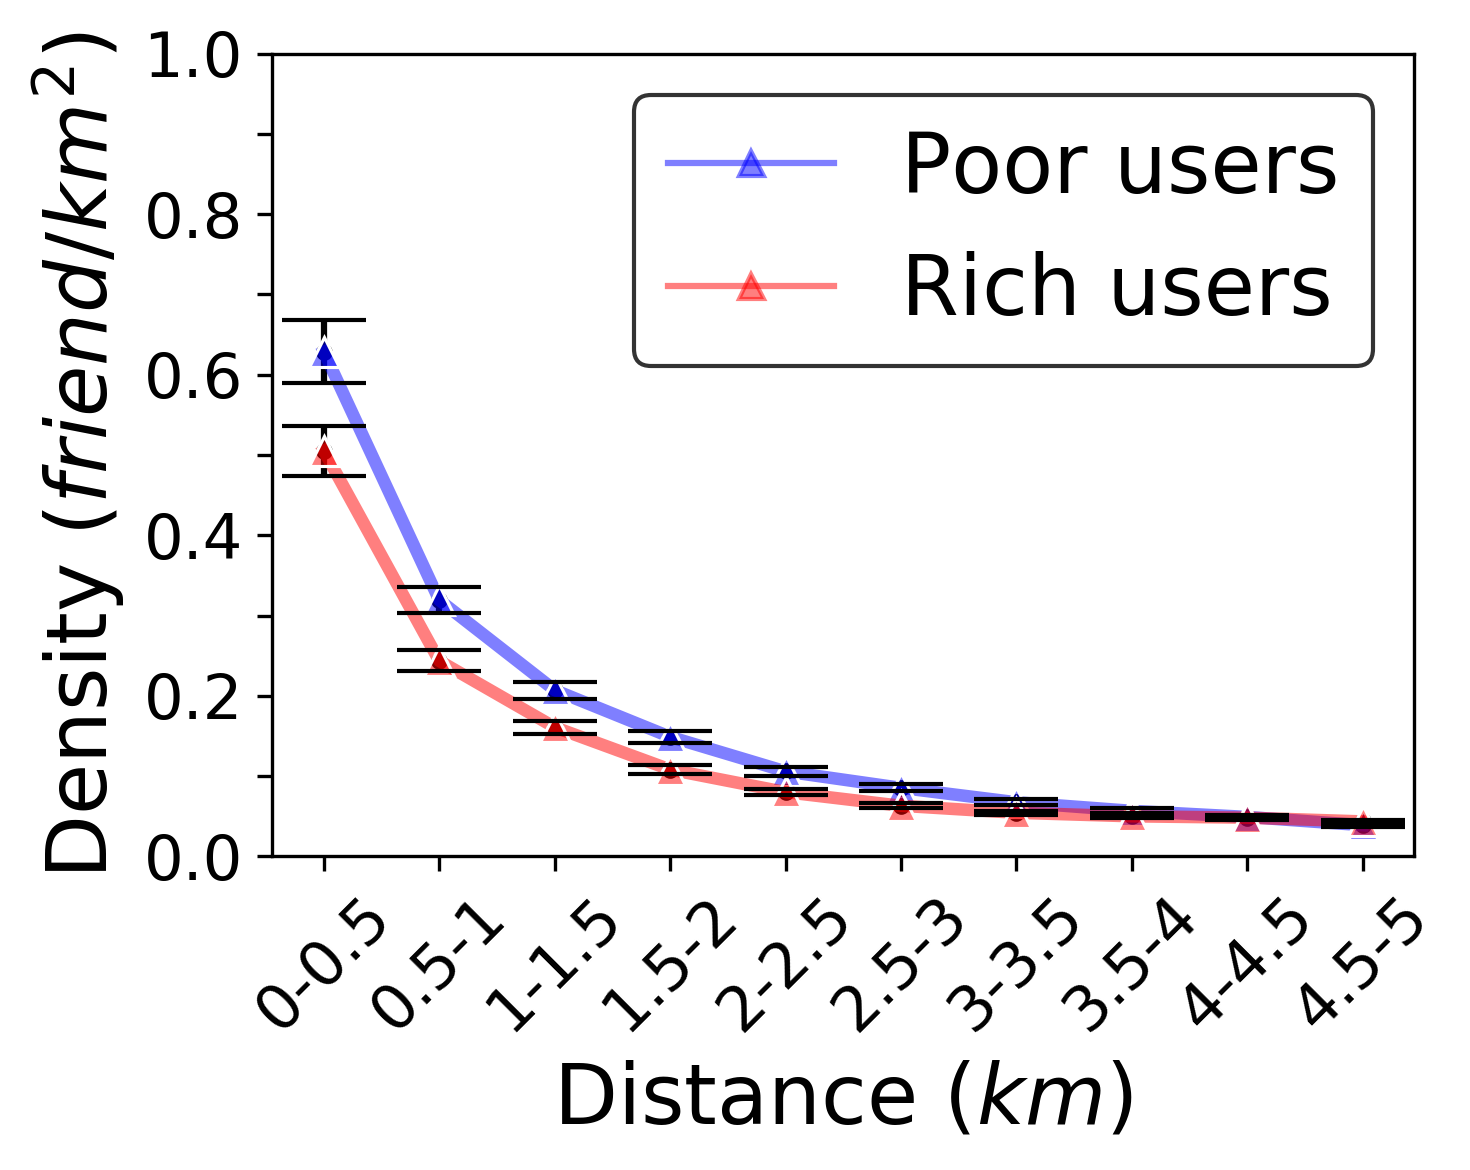

In [86]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

#colors of lines
colorsList = [(0.0, 0.0, 1.0,0.5),(1.0, 0.0, 0.0,0.5)]

#lineplot created
ax = sns.lineplot(data = conc1_short, x = 'distance', y = 'mean',  hue = 'type', style = 'type', palette = colorsList, dashes=False, ax = ax, markers=["^", "^"], markersize = 7, linewidth = 3)
ax.errorbar(data = conc1_short, x = 'distance', y = 'mean', yerr= [conc1_short['err_l'], conc1_short['err_u']], linestyle='', fmt = '.k', ecolor = 'black', capsize = 10, barsabove = True)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 20, edgecolor = 'black')
ax.set(xlabel='Distance $(km)$', ylabel='Density $(friend/km^2)$')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis = 'x',rotation = 45)
ax.set_ylim([0, 1])
ax.yaxis.set_major_locator(mtick.MultipleLocator(0.1))
for label in ax.yaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis = 'x',rotation = 45)

plt.tight_layout()

## Cumulative share of friends around home by income level

In [133]:
d_table_cum_share = pd.concat([d_table_cum.iloc[:,0], d_table_cum.iloc[:,42:82]], axis = 1)

In [134]:
geo_inside = d_table_cum_share.merge(user_geon[['user_id', 'geometry_h']], 'left')
geo_inside = gpd.GeoDataFrame(geo_inside)
geo_inside = geo_inside.set_geometry('geometry_h')

In [135]:
#merge to the tracts all the individuals who live there
merged_geo_inside = gpd.sjoin(geo_inside,merged[['geometry','inc_group_2']],'left','within')

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [136]:
merged_geo_inside = merged_geo_inside.drop(['index_right'], axis = 1)

In [137]:
merged_geo_inside.head()

,user_id,dh500_share,dh1000_share,dh1500_share,dh2000_share,dh2500_share,dh3000_share,dh3500_share,dh4000_share,dh4500_share,...,dw6500_share,dw7000_share,dw7500_share,dw8000_share,dw8500_share,dw9000_share,dw9500_share,dw10000_share,geometry_h,inc_group_2
0,47,0.0,0.102,0.119,0.153,0.153,0.186,0.203,0.254,0.356,...,0.746,0.780,0.797,0.847,0.864,0.881,0.881,0.881,POINT (-73.95600 40.71700),rich
1,850,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.062,0.062,0.062,POINT (-74.03400 40.98100),rich
2,977,0.1,0.100,0.100,0.200,0.300,0.300,0.300,0.300,0.400,...,0.400,0.400,0.400,0.400,0.400,0.500,0.500,0.600,POINT (-73.99700 40.72600),rich
3,1027,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,POINT (-73.79100 41.55800),rich
4,1135,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.812,0.812,0.812,0.812,0.812,0.875,0.875,0.875,POINT (-74.60000 40.53200),poor


In [138]:
len(merged_geo_inside[merged_geo_inside['inc_group_2'] == 'rich'])

5551

In [139]:
len(merged_geo_inside[merged_geo_inside['inc_group_2'] == 'poor'])

3677

In [140]:
merged_geo_inside_r = merged_geo_inside[merged_geo_inside['inc_group_2'] == 'rich']

In [141]:
merged_geo_inside_p = merged_geo_inside[merged_geo_inside['inc_group_2'] == 'poor']

In [142]:
merged_geo_inside_p_h = merged_geo_inside_p[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

In [143]:
merged_geo_inside_r_h = merged_geo_inside_r[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

### Home

In [231]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["poor"] * 20

for c in list(merged_geo_inside_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_inside_p_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb4 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb4 = pd.DataFrame(frameb4)

In [232]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["rich"] * 20

for c in list(merged_geo_inside_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_inside_r_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb5 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb5 = pd.DataFrame(frameb5)

In [236]:
conc1 = pd.concat([resultb4,resultb5]).reset_index(drop = True)

In [237]:
conc1

,dist,mean,err_l,err_u,lower,upper,type,distance
0,dh500_share,0.027462,0.001808,0.001893,0.025654,0.029355,poor,0.5
1,dh1000_share,0.067416,0.003051,0.003118,0.064365,0.070534,poor,1.0
2,dh1500_share,0.109988,0.004257,0.004242,0.105732,0.114231,poor,1.5
3,dh2000_share,0.150680,0.005167,0.005171,0.145514,0.155852,poor,2.0
4,dh2500_share,0.188108,0.005980,0.006004,0.182128,0.194113,poor,2.5
5,dh3000_share,0.224434,0.006532,0.006594,0.217902,0.231027,poor,3.0
6,dh3500_share,0.257954,0.007143,0.007257,0.250810,0.265211,poor,3.5
7,dh4000_share,0.290363,0.007527,0.007663,0.282836,0.298026,poor,4.0
8,dh4500_share,0.321502,0.007999,0.008146,0.313504,0.329649,poor,4.5
9,dh5000_share,0.348343,0.008414,0.008494,0.339928,0.356836,poor,5.0


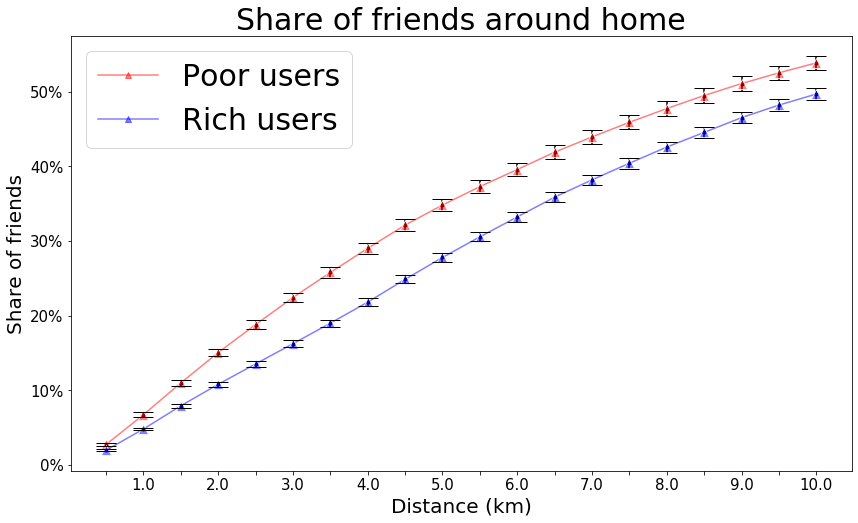

In [238]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(14, 8))

#colors of lines
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#lineplot created
ax = sns.lineplot(data = conc1, x = 'distance', y = 'mean', hue = 'type', style = 'type',palette = colorsList, dashes=False, ax = ax, markers=["^", "^"], markersize = 10)

ax.errorbar(data = conc1, x = 'distance', y = 'mean', yerr= [conc1['err_l'], conc1['err_u']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 30)
ax.set(xlabel='Distance (km)', ylabel='Share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax.set_title('Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

In [239]:
p = [conc1['mean'][1], conc1['mean'][9], conc1['mean'][19]]
r = [conc1['mean'][21], conc1['mean'][29], conc1['mean'][39]]

In [242]:
err_l_p = [conc1['err_l'][1], conc1['err_l'][9], conc1['err_l'][19]]
err_u_p = [conc1['err_u'][1], conc1['err_u'][9], conc1['err_u'][19]]
err_l_r = [conc1['err_l'][21], conc1['err_l'][29], conc1['err_l'][39]]
err_u_r = [conc1['err_u'][21], conc1['err_u'][29], conc1['err_u'][39]]

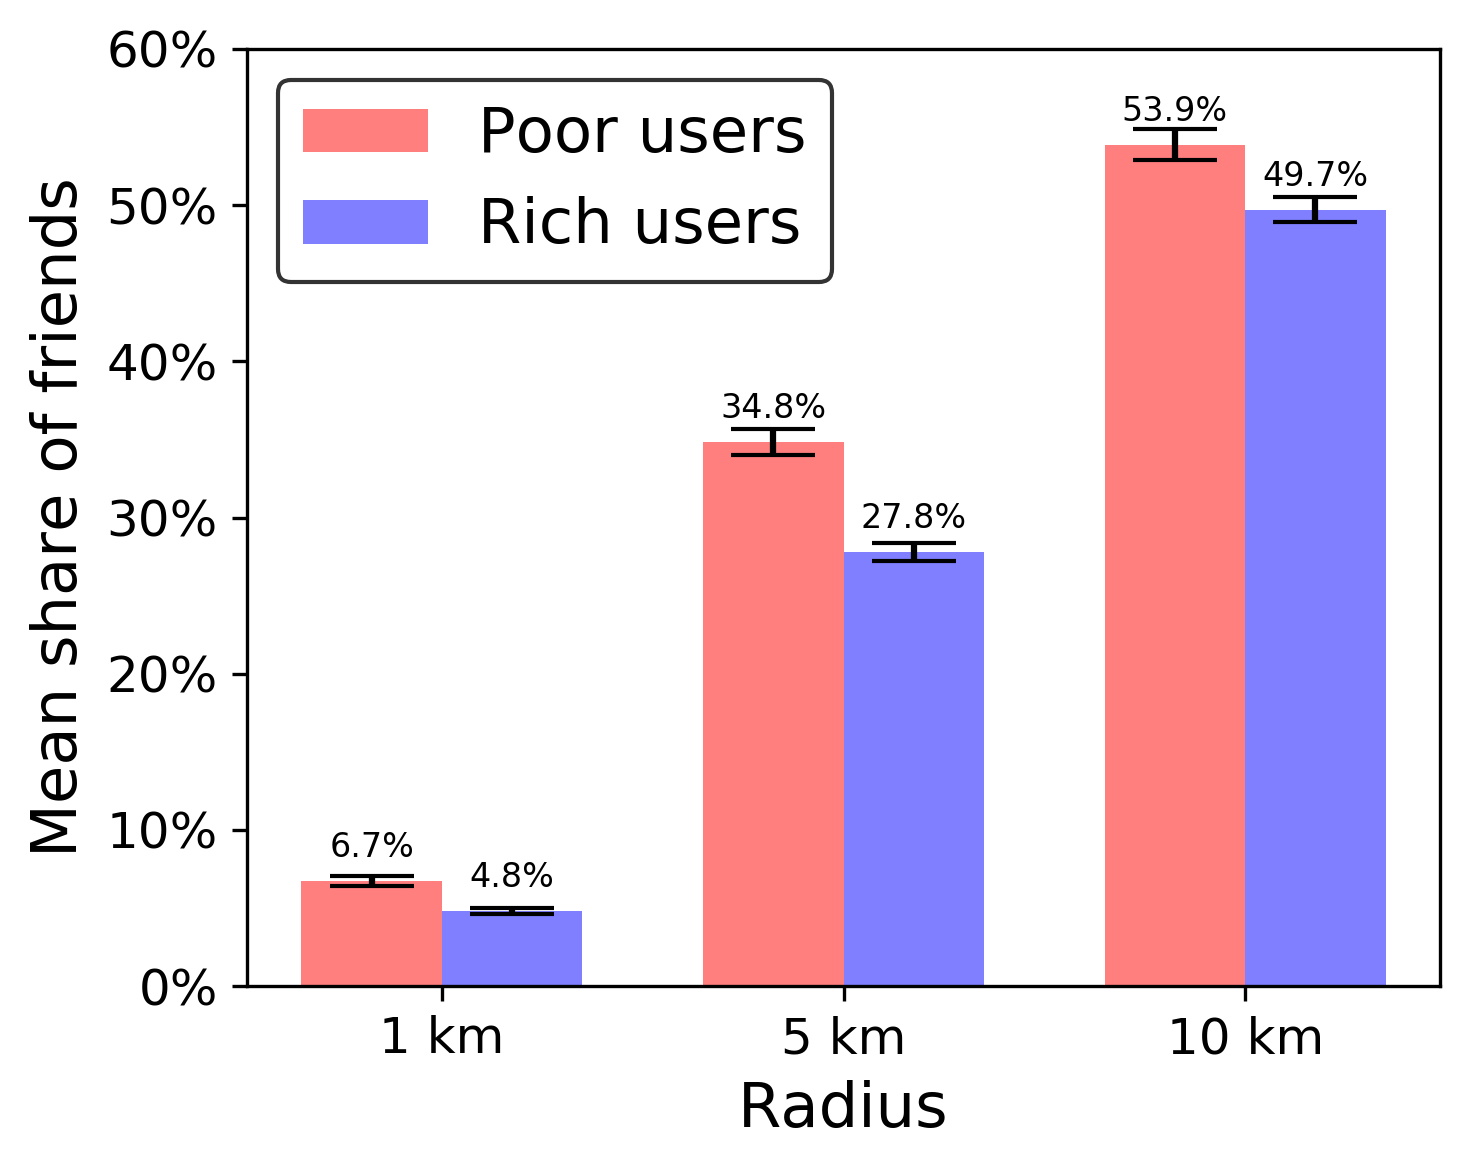

In [246]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

titles = ['1 km', '5 km', '10 km']
                                                                                                                    
#color of bars
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#bar plot created
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, p, color = colorsList[0], width = bar_width, label = 'Home ties', yerr = [err_l_p, err_u_p], capsize = 10)
rects2 = ax.bar(X + bar_width, r, color = colorsList[1], width = bar_width, label = 'Work ties', yerr = [err_l_r, err_u_r], capsize = 10) 

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, edgecolor = 'black')
ax.set(ylabel='Mean share of friends')
ax.set(xlabel='Radius')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

### Change in share of friends

In [199]:
d_table_share = pd.concat([d_table.iloc[:,0], d_table.iloc[:,42:82]], axis = 1)

In [200]:
geo_in = d_table_share.merge(user_geon[['user_id', 'geometry_h']], 'left')
geo_in = gpd.GeoDataFrame(geo_in)
geo_in = geo_in.set_geometry('geometry_h')

In [201]:
#merge to the tracts all the individuals who live there
merged_geo_in = gpd.sjoin(geo_in,merged[['geometry','inc_group_2']],'left','within')

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [203]:
merged_geo_in = merged_geo_in.drop(['index_right'], axis = 1)

In [204]:
merged_geo_in.head()

,user_id,dh500_share,dh1000_share,dh1500_share,dh2000_share,dh2500_share,dh3000_share,dh3500_share,dh4000_share,dh4500_share,...,dw6500_share,dw7000_share,dw7500_share,dw8000_share,dw8500_share,dw9000_share,dw9500_share,dw10000_share,geometry_h,inc_group_2
0,47,0.0,0.102,0.017,0.034,0.0,0.034,0.017,0.051,0.102,...,0.051,0.034,0.017,0.051,0.017,0.017,0.0,0.0,POINT (-73.95600 40.71700),rich
1,850,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0,POINT (-74.03400 40.98100),rich
2,977,0.1,0.000,0.000,0.100,0.1,0.000,0.000,0.000,0.100,...,0.000,0.000,0.000,0.000,0.000,0.100,0.0,0.1,POINT (-73.99700 40.72600),rich
3,1027,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,POINT (-73.79100 41.55800),rich
4,1135,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.0,POINT (-74.60000 40.53200),poor


In [205]:
len(merged_geo_in[merged_geo_in['inc_group_2'] == 'rich'])

5551

In [206]:
len(merged_geo_in[merged_geo_in['inc_group_2'] == 'poor'])

3677

In [207]:
merged_geo_in_r = merged_geo_in[merged_geo_in['inc_group_2'] == 'rich']

In [208]:
merged_geo_in_p = merged_geo_in[merged_geo_in['inc_group_2'] == 'poor']

In [209]:
merged_geo_in_p_h = merged_geo_in_p[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

In [210]:
merged_geo_in_r_h = merged_geo_in_r[['dh500_share','dh1000_share', 'dh1500_share','dh2000_share',
                     'dh2500_share','dh3000_share', 'dh3500_share','dh4000_share', 
                     'dh4500_share', 'dh5000_share', 'dh5500_share','dh6000_share',
                     'dh6500_share', 'dh7000_share','dh7500_share','dh8000_share',
                     'dh8500_share', 'dh9000_share','dh9500_share','dh10000_share']]

### Home

In [212]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["poor"] * 20

for c in list(merged_geo_in_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_in_p_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb6 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb6 = pd.DataFrame(frameb6)

In [213]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
annotations = np.linspace(0.5,10,20)
type1 = ["rich"] * 20

for c in list(merged_geo_in_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(merged_geo_in_r_h[str(c)], np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb7 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1, 'distance': annotations}
resultb7 = pd.DataFrame(frameb7)

In [214]:
conc2 = pd.concat([resultb6,resultb7])

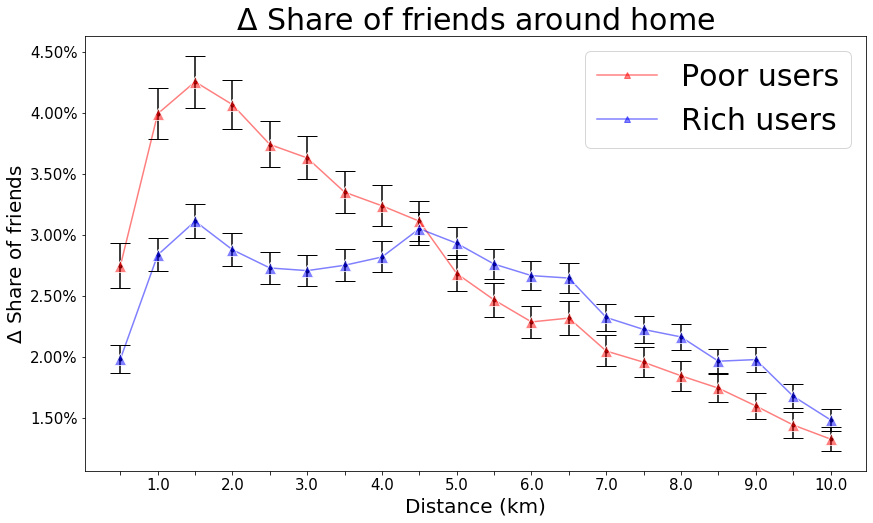

In [218]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(14, 8))

#colors of lines
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]

#lineplot created
ax = sns.lineplot(data = conc2, x = 'distance', y = 'mean', hue = 'type', style = 'type',palette = colorsList, dashes=False, ax = ax, markers=["^", "^"], markersize = 12)

ax.errorbar(data = conc2, x = 'distance', y = 'mean', yerr= [conc2['err_l'], conc2['err_u']], linestyle='', fmt = '.k', barsabove = True, capsize = 10)

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['Poor users', 'Rich users'], fontsize = 30)
ax.set(xlabel='Distance (km)', ylabel='$\Delta$ Share of friends')
ax.xaxis.label.set_fontsize(20)
ax.yaxis.label.set_fontsize(20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1)) 
ax.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax.set_title('$\Delta$ Share of friends around home', size = 30)
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

## Clustering and support

### Clustering

#### Home

In [150]:
list1 = []

for user in tqdm_notebook(d_table['user_id']):
    time.sleep(.01)
    r = {}
    r['user_id'] = user
    for dist in [1000, 5000, 10000]:
        #get third edges
        lista = list(geo_edgelistn[(geo_edgelistn['user_id1'] == user) & (geo_edgelistn['dh_bin'] <= dist)]['user_id2'])
        if len(lista) < 2:
            r['clusth' + str(dist)] = np.nan
        else:
            a = geo_edgelistn[geo_edgelistn['user_id1'].isin(lista)]
            b = a[a['user_id2'].isin(lista)][['user_id1', 'user_id2']]
            #get df with ego network and below the third edges
            c = pd.concat([geo_edgelistn[geo_edgelistn['user_id1'] == user][['user_id1', 'user_id2']], b], ignore_index = True)

            G = nx.from_pandas_edgelist(c, 'user_id1', 'user_id2')
            r['clusth' + str(dist)] = nx.average_clustering(G)        
    list1.append(r)
clust_table_h = pd.DataFrame(list1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [203]:
clust_table_h.to_csv("../data/clust_table_h.csv")

In [153]:
clust_table_h = pd.read_csv("../data/clust_table_h.csv", index_col=0)

In [154]:
clust_table_h.head()

,user_id,clusth1000,clusth5000,clusth10000
0,47,0.0,0.229054,0.529399
1,850,NaN,NaN,NaN
2,977,NaN,0.202778,0.202778
3,1027,NaN,NaN,NaN
4,1135,NaN,NaN,NaN


   ## Separate by income level

In [159]:
cluster = pd.merge(clust_table_h, user_geon[['user_id', 'geometry_h']], 'left', on = 'user_id')

In [160]:
cluster = gpd.GeoDataFrame(cluster)
cluster = cluster.set_geometry('geometry_h')

In [161]:
#merge to the tracts all the individuals who live there
cluster = gpd.sjoin(cluster,merged[['inc_group_2', 'geometry']],'left','within')
cluster = cluster.drop(['index_right'], axis = 1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [162]:
cluster.head()

,user_id,clusth1000,clusth5000,clusth10000,geometry_h,inc_group_2
0,47,0.0,0.229054,0.529399,POINT (-73.95600 40.71700),rich
1,850,NaN,NaN,NaN,POINT (-74.03400 40.98100),rich
2,977,NaN,0.202778,0.202778,POINT (-73.99700 40.72600),rich
3,1027,NaN,NaN,NaN,POINT (-73.79100 41.55800),rich
4,1135,NaN,NaN,NaN,POINT (-74.60000 40.53200),poor


In [163]:
cluster_r = cluster[cluster['inc_group_2'] == 'rich']

In [164]:
cluster_p = cluster[cluster['inc_group_2'] == 'poor']

In [165]:
cluster_p_h = cluster_p[['clusth1000', 'clusth5000', 'clusth10000']]

In [166]:
cluster_r_h = cluster_r[['clusth1000', 'clusth5000', 'clusth10000']]

In [167]:
len(cluster_p_h['clusth1000'].dropna())

1103

### Home

In [168]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["poor"] * 3

for c in list(cluster_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(cluster_p_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb8 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb8 = pd.DataFrame(frameb8)

In [169]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["rich"] * 3

for c in list(cluster_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(cluster_r_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb9 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb9 = pd.DataFrame(frameb9)

In [170]:
conc3 = pd.concat([resultb8,resultb9])

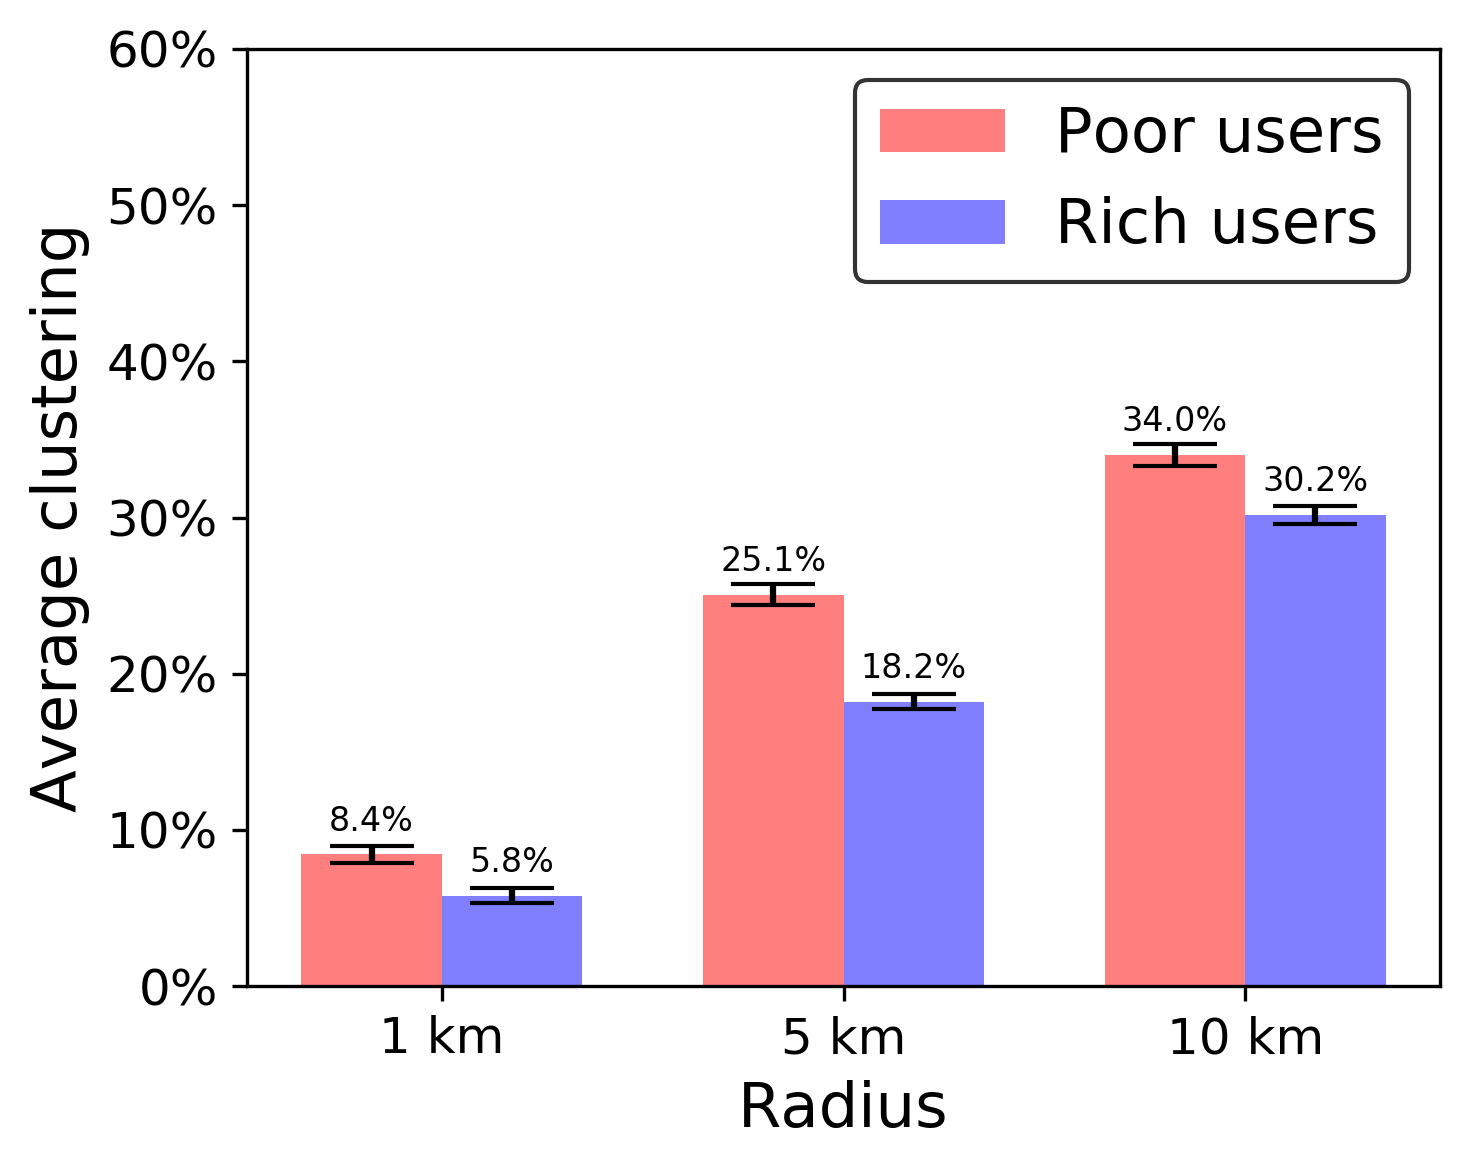

In [193]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

titles = ['1 km', '5 km', '10 km']

#colors of bars
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]
                                                                                                                    
#bar plot created
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, conc3[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [conc3[0:3]['err_l'], conc3[0:3]['err_u']], capsize = 10)
rects2 = ax.bar(X + bar_width, conc3[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [conc3[3:]['err_l'], conc3[3:]['err_u']], capsize = 10) 

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, edgecolor = 'black')
ax.set(ylabel='Average clustering')
ax.set(xlabel='Radius')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 0.6])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 4),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

#plt.savefig('../figures/clustering_home_inc.jpg')

### Support

### Home

In [1037]:
list2 = []

for user in tqdm_notebook(d_table['user_id']):
    r = {}
    r['user_id'] = user
    for dist in [1000, 5000, 10000]:
        #get third edges
        lista2 = list(geo_edgelistn[(geo_edgelistn['user_id1'] == user) & (geo_edgelistn['dh_bin'] <= dist)]['user_id2'])
        if len(lista2) < 2:
            r['suph' + str(dist)] = np.nan
        else:
            a = geo_edgelistn[geo_edgelistn['user_id1'].isin(lista2)]
            b = a[a['user_id2'].isin(lista2)][['user_id1', 'user_id2']]
                       
            r['suph' + str(dist)] = len(b['user_id1'].unique()) / len(lista2) 
    list2.append(r)
sup_table_h = pd.DataFrame(list2)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [1038]:
sup_table_h.to_csv("../data/sup_table_h.csv")

In [172]:
sup_table_h = pd.read_csv("../data/sup_table_h.csv", index_col=0)

In [174]:
sup_table_h.head()

,user_id,suph1000,suph5000,suph10000
0,47,0.0,0.75,0.90566
1,850,NaN,NaN,NaN
2,977,NaN,1.00,1.00000
3,1027,NaN,NaN,NaN
4,1135,NaN,NaN,NaN


In [1045]:
sup_table = sup_table_h.merge(sup_table_w, 'left', on = 'user_id')
sup_table2 = sup_table.iloc[:,1:]
sup_table2.head()

,suph1000,suph5000,suph10000,supw1000,supw5000,supw10000
0,0.0,0.75,0.90566,0.0,0.733333,0.884615
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.00,1.00000,NaN,1.000000,1.000000
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.5,0.700000,0.714286


In [178]:
support = pd.merge(sup_table_h, user_geon[['user_id', 'geometry_h']], 'left', on = 'user_id')
support = gpd.GeoDataFrame(support)
support = support.set_geometry('geometry_h')

In [179]:
#merge to the tracts all the individuals who live there
support = gpd.sjoin(support,merged[['inc_group_2', 'geometry']],'left','within')
support = support.drop(['index_right'], axis = 1)

C:\Users\T440s\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: +init=epsg:4326 +type=crs

  


In [180]:
support.head()

,user_id,suph1000,suph5000,suph10000,geometry_h,inc_group_2
0,47,0.0,0.75,0.90566,POINT (-73.95600 40.71700),rich
1,850,NaN,NaN,NaN,POINT (-74.03400 40.98100),rich
2,977,NaN,1.00,1.00000,POINT (-73.99700 40.72600),rich
3,1027,NaN,NaN,NaN,POINT (-73.79100 41.55800),rich
4,1135,NaN,NaN,NaN,POINT (-74.60000 40.53200),poor


In [181]:
support_r = support[support['inc_group_2'] == 'rich']

In [182]:
support_p = support[support['inc_group_2'] == 'poor']

In [183]:
support_p_h = support_p[['suph1000', 'suph5000', 'suph10000']]

In [184]:
support_r_h = support_r[['suph1000', 'suph5000', 'suph10000']]

### Home

In [185]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["poor"] * 3

for c in list(support_p_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(support_p_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb12 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb12 = pd.DataFrame(frameb12)

In [186]:
rownames = []
means = []
uppers = []
lowers = []
errs_l  = []
errs_u =[]
type1 = ["rich"] * 3

for c in list(support_r_h.columns):
    rownames.append(str(c))
    a = draw_bs_replicates(support_r_h[str(c)].dropna(), np.mean, 15000)
    means.append(np.mean(a))
    lowers.append(np.percentile(a,2.5))
    uppers.append(np.percentile(a,97.5))
    errs_l.append((np.mean(a) - np.percentile(a,2.5)))
    errs_u.append((np.percentile(a,97.5) - np.mean(a)))
    
frameb13 = { 'dist': rownames , 'mean': means, 'err_l': errs_l,'err_u': errs_u, 'lower': lowers, 'upper': uppers, 'type': type1}
resultb13 = pd.DataFrame(frameb13)

In [187]:
conc5 = pd.concat([resultb12,resultb13])

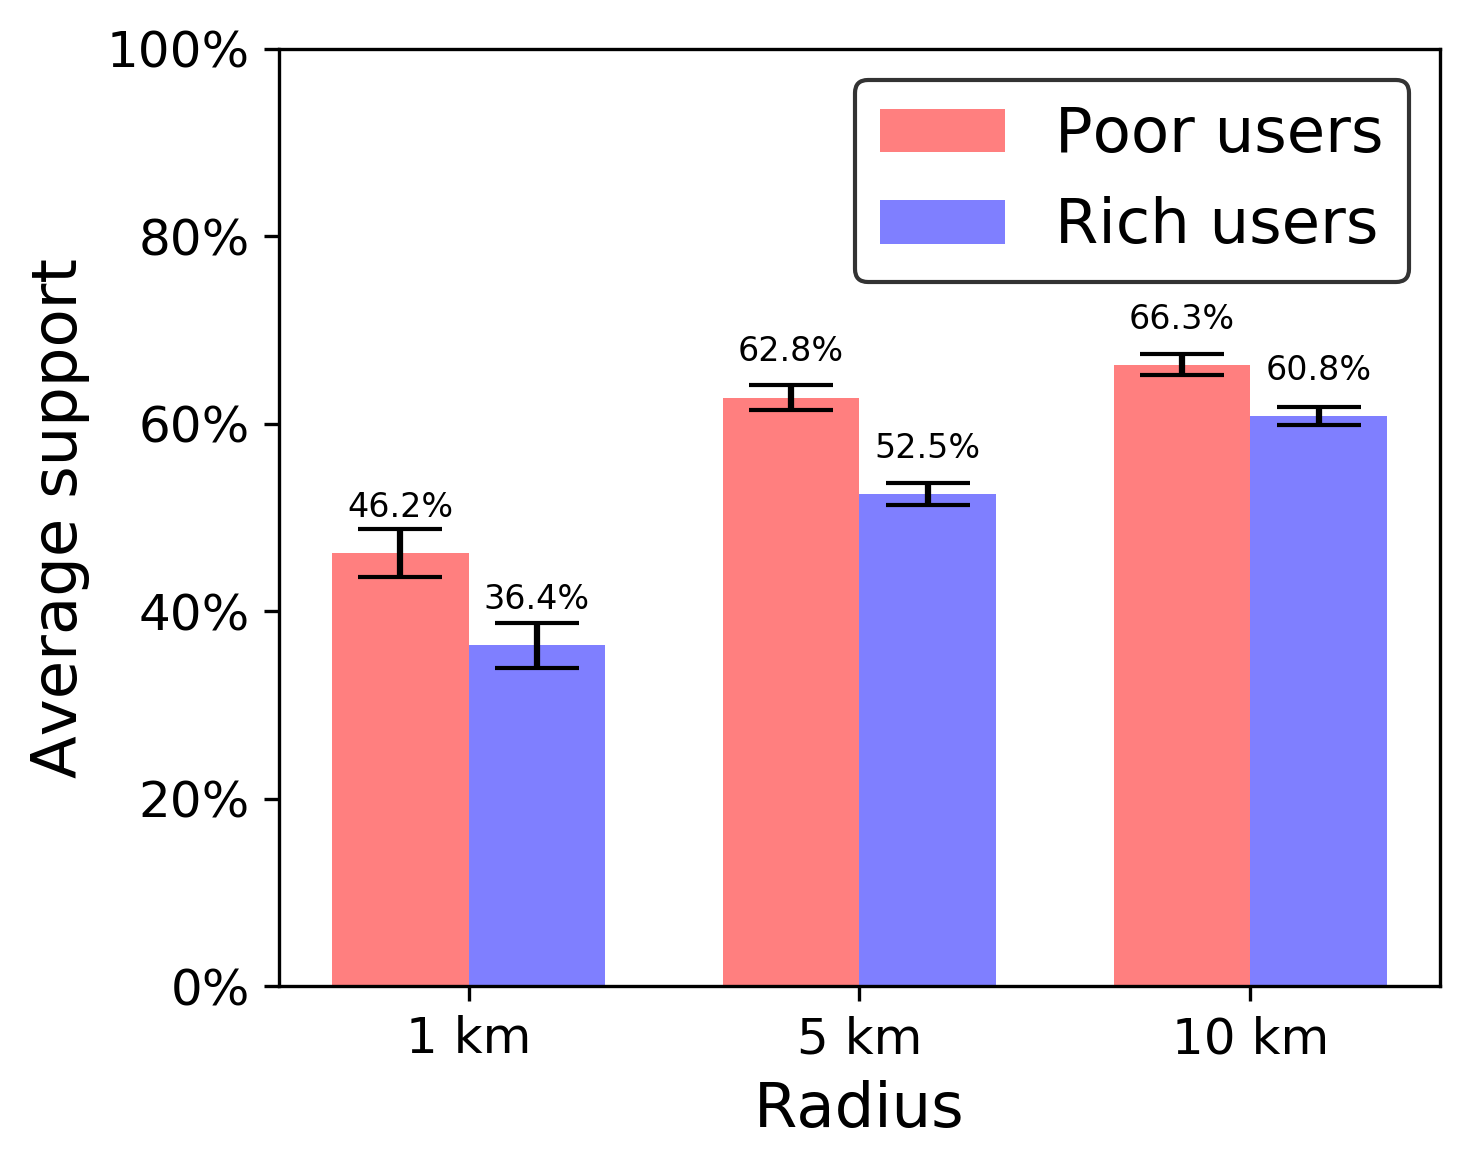

In [192]:
#parameters of chart
fig, ax = plt.subplots(1,1, figsize=(5, 4), dpi=300)

titles = ['1 km', '5 km', '10 km']

#colors of bars
colorsList = [(1.0, 0.0, 0.0,0.5),(0.0, 0.0, 1.0,0.5)]
                                                                                                                    
#bar plot created
X = np.arange(3)
bar_width = 0.35
rects1 = ax.bar(X, conc5[0:3]['mean'], color = colorsList[0], width = bar_width, label = 'Poor users', yerr = [conc5[0:3]['err_l'], conc5[0:3]['err_u']], capsize = 10)
rects2 = ax.bar(X + bar_width, conc5[3:]['mean'], color = colorsList[1], width = bar_width, label = 'Rich users', yerr = [conc5[3:]['err_l'], conc5[3:]['err_u']], capsize = 10) 

#customize labels and legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels=['Poor users', 'Rich users'], fontsize = 15, edgecolor = 'black')
ax.set(ylabel='Average support')
ax.set(xlabel='Radius')
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0)) 
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(X + bar_width/2)
ax.set_xticklabels(['1 km', '5 km', '10 km'])
ax.set_ylim([0, 1])

#function used for labelling
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.1%}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = 8)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

#plt.savefig('../figures/support_home_inc.jpg')